# Sentiment Classification with Bi-LSTM

In [1]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

device

device(type='cuda')

## Load Data

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('./data/train.csv')
X = df['text']
Y = df['suicide']

In [3]:
sentences = [sen for sen in X]

sentences[: 5]

["It makes me happy to think that I'd rather commit suicide than to live an unhappy lifeAt least that is something that many of the people who are not suicidal cannot do.\n\nI used to worry a lot about my future being worried about if I fuck things up and I create a bad ad unhappy life for me that I'd have to deal for the rest of my life, but now that I know that I can just end it all if things go bad, that makes me feel much better for some reason...",
 "My dad got the Corona Virus... Please pray for hi am ya'll 🥺",
 'the everlasting question why is this art!!!!!!1211111!!!!!',
 'If someone ik finds my reddit acct i am saying someone catfished using my pictures ong Im a loser but i could at least try to hide it 🥴',
 "I lost everything in span of a month.Hey guys, \n\numm...so I'm pretty shook up right now. \n\nLast month the woman who I thought I will marry left me five years into our relationship. \n\nI sort of dealt with it and did my best to move on...got my own place and started t

In [4]:
sen_labels = torch.tensor(Y.values)

sen_labels[: 5]

tensor([1, 0, 0, 0, 1])

## Pre-processing data

In [5]:
from transformers import BertTokenizer

# get pre-trained tokenizer model
tokenizer = BertTokenizer.from_pretrained('./pretrained/bert-base-uncased')

tokenizer

BertTokenizer(name_or_path='./pretrained/bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [6]:
max_length = 512

tokenized = tokenizer(sentences, padding=True, truncation=True, max_length=max_length, return_tensors='pt')

sen_ids = tokenized['input_ids']

print(sen_ids.size())

torch.Size([185659, 512])


## Releasing memory

In [7]:
del tokenizer
del tokenized
del sentences
del X
del Y
del df

import gc
gc.collect()

21

## Build the model

```
LSTMClassifier(
  (embedding_layer): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (lstm): LSTM(768, hidden_size, num_layers, batch_first=True, dropout=0.2, bidirectional=True)
  (output_layer): Linear(in_features=2 * hidden_size, out_features=2, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
)
```

In [8]:
import torch.nn as nn
from transformers.models.bert.modeling_bert import BertEmbeddings
from transformers import AutoConfig

class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_classes, num_layers, device, drop_prob=0.2):
        super(LSTMClassifier, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = num_layers
        self.device = device

        config = AutoConfig.from_pretrained('./pretrained/bert-base-uncased')
        self.embedding_layer = BertEmbeddings(config)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, bidirectional=True, dropout=drop_prob, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim * 2, num_classes)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(drop_prob)

    def forward(self, input, hidden):
        embedded = self.embedding_layer(input) # (batch_size, seq_length, embedding_size)
        lstm_out, hidden = self.lstm(embedded, hidden) # (batch_size, seq_length, hidden_size)
        out = self.dropout(lstm_out)
        out = self.output_layer(out) # (batch_size, seq_length, num_classes)
        out = self.sigmoid(out)
        out = out[:, -1, :]
        return out, hidden

    def init_hidden(self, batch_size):
        hidden = (torch.zeros(self.n_layers * 2, batch_size, self.hidden_dim).to(self.device),
                  torch.zeros(self.n_layers * 2, batch_size, self.hidden_dim).to(self.device))
        return hidden

## Cross Validation

A stratified 5-fold cross validation will be applied to the model.

### Training method

In [9]:
# training model
def model_train(model, train_dataloader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        train_losses = []

        model.train()
        for i, batch_data in enumerate(train_dataloader):
            input_ids, input_labels = tuple(data.to(device) for data in batch_data)
            cur_batch = len(input_ids)
            hidden = model.init_hidden(cur_batch)

            optimizer.zero_grad()
            output, hidden =  model(input_ids, hidden)

            loss = criterion(output, input_labels)
            train_losses.append(loss.item())

            loss.backward()
            optimizer.step()

        print("Epoch: {}/{}".format((epoch + 1), epochs),
              "\n\tTraining Loss: {:.4f}".format(np.mean(train_losses)))
        
    return model

### Validation method

In [28]:
from sklearn.metrics import accuracy_score

# validation model
def model_validation(model, val_dataloader, criterion):
    val_losses = []
    pred_list, label_list = [], []

    model.eval()
    for batch_data in val_dataloader:
        input_ids, input_labels = tuple(data.to(device) for data in batch_data)

        cur_batch = len(input_ids)
        hidden = model.init_hidden(cur_batch)

        with torch.no_grad():
            preds, hidden = model(input_ids, hidden)

        loss = criterion(preds, input_labels)
        val_losses.append(loss.item())
        preds = preds.detach().to('cpu').numpy()
        labels = input_labels.to('cpu').numpy()
        preds = preds.argmax(1) # shape = [1, : ]

        # record all predicted labels and true labels
        pred_list = np.concatenate((pred_list, preds))
        label_list = np.concatenate((label_list, labels))

    # Calculate the accuracy score of all datas in validation set
    AccuracyScore = accuracy_score(label_list, pred_list)

    print("Validation Loss: {:.4f}".format(np.mean(val_losses)),
          "Validation Accuracy: {:.4f}%".format(AccuracyScore * 100))
    
    return pred_list, label_list

### Train and validate

In [51]:
# parameters
embedding_dim = 768
hidden_size = [32, 64, 128]
num_classes = 2
num_layers = [2, 3]

learning_rate = [0.0001, 0.0005, 0.001]
epochs = 4

In [35]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
from sklearn.metrics import recall_score, precision_score, f1_score


skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=60)
acc_list, rec_list, pre_list, f1_list = [], [], [], []

for lr in learning_rate:
    print('learning_rate = ', lr)
    layer_acc, layer_rec, layer_pre, layer_f1 = [], [], [], [] # (len(num_layers), len(hidden_size),)

    for num_layer in num_layers:
        print('num_layers = ', num_layer)
        hid_acc, hid_rec, hid_pre, hid_f1 = [], [], [], [] # (len(hidden_size),)

        for hidden in hidden_size:
            print('hidden_size = ', hidden)
            accuracy_score_list, recall_score_list, precision_score_list, f1_score_list = [], [], [], [] # (n_splits,)

            for time, (train_index, val_index) in enumerate(skfolds.split(sen_ids, sen_labels)):
                print('Time: ', time + 1)
                X_train, X_val = sen_ids[train_index], sen_ids[val_index]
                Y_train, Y_val = sen_labels[train_index], sen_labels[val_index]

                # pack dataloaders
                train_dataset = TensorDataset(X_train, Y_train)
                val_dataset = TensorDataset(X_val, Y_val)

                batch_size = 32
                train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

                model = LSTMClassifier(embedding_dim, hidden, num_classes, num_layer, device)
                model = model.cuda()

                # optimizer
                optimizer = optim.Adam(model.parameters(), lr)
                # loss function
                criterion = nn.CrossEntropyLoss()

                # train model
                model = model_train(model, train_dataloader, criterion, optimizer, epochs)

                # validate model
                pred_list, label_list = model_validation(model, val_dataloader, criterion)

                # Evaluate model
                AccuracyScore = accuracy_score(label_list, pred_list)
                RecallScore = recall_score(label_list, pred_list)
                PrecisionScore = precision_score(label_list, pred_list)
                F1Score = f1_score(label_list, pred_list)

                # Add to lists
                accuracy_score_list.append(AccuracyScore)
                recall_score_list.append(RecallScore)
                precision_score_list.append(PrecisionScore)
                f1_score_list.append(F1Score)

            hid_acc.append(np.average(accuracy_score_list))
            hid_rec.append(np.average(recall_score_list))
            hid_pre.append(np.average(precision_score_list))
            hid_f1.append(np.average(f1_score_list))

        layer_acc.append(hid_acc)
        layer_rec.append(hid_rec)
        layer_pre.append(hid_pre)
        layer_f1.append(hid_f1)

    acc_list.append(layer_acc)
    rec_list.append(layer_rec)
    pre_list.append(layer_pre)
    f1_list.append(layer_f1)

learning_rate =  0.0001
num_layers =  2
hidden_size =  32
Time:  1
Epoch: 1/4 
	Training Loss: 0.6765
Epoch: 2/4 
	Training Loss: 0.6609
Epoch: 3/4 
	Training Loss: 0.6589
Epoch: 4/4 
	Training Loss: 0.5544
Validation Loss: 0.5198 Validation Accuracy: 80.2839%
Time:  2
Epoch: 1/4 
	Training Loss: 0.6375
Epoch: 2/4 
	Training Loss: 0.5339
Epoch: 3/4 
	Training Loss: 0.4776
Epoch: 4/4 
	Training Loss: 0.4376
Validation Loss: 0.4194 Validation Accuracy: 88.7402%
Time:  3
Epoch: 1/4 
	Training Loss: 0.6769
Epoch: 2/4 
	Training Loss: 0.5504
Epoch: 3/4 
	Training Loss: 0.4833
Epoch: 4/4 
	Training Loss: 0.4547
Validation Loss: 0.4366 Validation Accuracy: 87.2320%
Time:  4
Epoch: 1/4 
	Training Loss: 0.6760
Epoch: 2/4 
	Training Loss: 0.5486
Epoch: 3/4 
	Training Loss: 0.4947
Epoch: 4/4 
	Training Loss: 0.4580
Validation Loss: 0.4534 Validation Accuracy: 85.9340%
Time:  5
Epoch: 1/4 
	Training Loss: 0.6721
Epoch: 2/4 
	Training Loss: 0.5504
Epoch: 3/4 
	Training Loss: 0.6601
Epoch: 4/4 
	Tra

In [53]:
acc_list

[[[0.8537641221607404, 0.84042298186216, 0.9259179352803869],
  [0.8897546800369852, 0.9031880618278946, 0.9157756906943824]],
 [[0.8989867592162355, 0.9278138672754925, 0.940719309337139],
  [0.9094954844738259, 0.8786698206114624, 0.9241135599535524]],
 [[0.9340616598928848, 0.8119764703215313, 0.9363888243351675],
  [0.8525958253734686, 0.7653825768801024, 0.8551488899324055]]]

### Show Hyperparameter tuning results

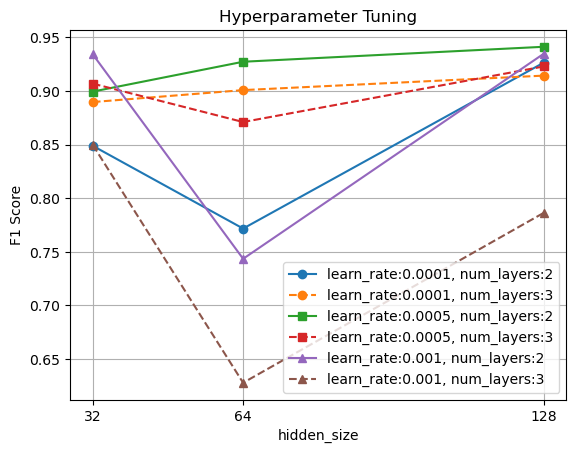

In [52]:
import matplotlib.pyplot as plt

mk = ['o', 's', '^']
ls = ['-', '--']

for i in range(3):
    for j in range(2):
        label = 'learn_rate:{}, num_layers:{}'.format(learning_rate[i], num_layers[j])
        plt.plot(hidden_size, f1_list[i][j], marker=mk[i], linestyle=ls[j], label=label)

plt.xlabel('hidden_size')
plt.ylabel('F1 Score')
plt.xticks(hidden_size, ['32', '64', '128'])
plt.title('Hyperparameter Tuning')
plt.legend()
plt.grid(True)
plt.savefig('./img/lstm_tuning.jpg')
plt.show()

### Choose the best Hyperparameters combo

In [47]:
hidden_size = 128
learning_rate = 0.0005
num_layers = 2

## Training model with chosen Hyperparameters and Save the model

In [48]:
train_dataset = TensorDataset(sen_ids, sen_labels)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = LSTMClassifier(embedding_dim, hidden_size, num_classes, num_layers, device)
model = model.cuda()

optimizer = optim.Adam(model.parameters(), learning_rate)

criterion = nn.CrossEntropyLoss()

# train model
model = model_train(model, train_dataloader, criterion, optimizer, epochs)

Epoch: 1/4 
	Training Loss: 0.6009
Epoch: 2/4 
	Training Loss: 0.4554
Epoch: 3/4 
	Training Loss: 0.4141
Epoch: 4/4 
	Training Loss: 0.4037


In [49]:
net_state_dict = model.state_dict()

torch.save(net_state_dict, './model/LSTM_classifier.pt')

to load the model:

```python
m_state_dict = torch.load('./model/LSTM_classifier.pt')
model = LSTMClassifier(768, 128, 2, 2, device)
model.load_state_dict(m_state_dict)
```

## Save tuning results

In [55]:
with open('./data/acc.csv', 'w') as f:
    for i in acc_list:
        np.savetxt(f, i)

with open('./data/rec.csv', 'w') as f:
    for i in rec_list:
        np.savetxt(f, i)

with open('./data/pre.csv', 'w') as f:
    for i in pre_list:
        np.savetxt(f, i)

with open('./data/f1.csv', 'w') as f:
    for i in f1_list:
        np.savetxt(f, i)